# Experiment 2: Do V20 lake fields + some extra surface fields improve our predicitions?

We compare two models:

* `V15`: A model using time variable features + `'cl_v15','lsm_v15','dl_v15','cvl_v15','cvh_v15','anor_v15','isor_v15','slor_v15','sr_v15','lsrh_v15'`
* `V20`: A model using time variable features, the above `*_v15` fields + corresponding V20 corrections for all the 

The correction is obtained by calculating e.g. `cl_V20 - cl_V15`.

To see how these fields change when going from V15 to V20, check out the `A1.V20_vs_V15.ipynb` notebook in this directory.

---



# 1. Plot model performance and difference

We have a V15 model which has some error relative to the true, observed data.

Ditto a V20 model.

Lets plot the error maps for each of these models, and also plot the difference in the error maps.

In [45]:
import pandas as pd
import json
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.colors as mc
import matplotlib.colorbar as cb 


def load_predictions(path):

    df = pd.read_pickle(path+'predictions.pkl')
    df['model_error'] = df.MODIS_LST - df.predictions
    df['absolute_model_error'] = abs(df.MODIS_LST - df.predictions)

    
    return df

def plot_training_history(path,logscale,jump_n_epochs,upper_limit,lower_limit):
    
    print('Path =', path)
    
    with open(path+'meta.txt') as f:
        lines = f.readlines()
        print(*lines)
        #print( [row for row in lines])
    
    
    
    
    with open(path+'history.json') as f:
        d = json.load(f)
        i = jump_n_epochs
        training_loss = d['loss'][i:]
        epochs = np.arange(len(training_loss))
        
        
        idxmin = np.argmin(training_loss)
        

        fig = plt.figure(figsize=(10, 10))
        plt.plot(epochs,training_loss,label='training loss')
        plt.scatter(epochs[idxmin],training_loss[idxmin])

        try:
            validation_loss = d['val_loss'][i:]
            idxmin = np.argmin(validation_loss)
            plt.plot(epochs,validation_loss, label='validation loss')
            plt.scatter(epochs[idxmin],validation_loss[idxmin])
            print('Minimum validation loss:',validation_loss[idxmin])

        except:
            pass
        plt.legend()
        
        if logscale:
            plt.yscale('log')
            
            
        plt.ylim(lower_limit,upper_limit)
        print('----------------------------------------------')


def plot_map(ds,z,vmin,vmax,cmap,logscale,title,limits,markersize):
    
    """Scatter plot. Bit hacky. """

    try:
        x = ds.longitude
        y = ds.latitude
    except: #different sources call lat/lon different things
        x = ds.longitude_ERA
        y = ds.latitude_ERA
    
    z1 = ds[z]
    

    
    #Setup figure and axes
    fig = plt.figure(figsize=[30,20])
    gs = GridSpec(1, 2, figure=fig, width_ratios=[50,1])
    ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=0))
    cax = fig.add_subplot(gs[1])
    
    #Cmaps, normalisations
    if logscale:
        norm = mc.LogNorm(vmin=vmin, vmax=vmax)
        z1 = abs(z1)
    else:
        norm = mc.Normalize(vmin=vmin, vmax=vmax)

    
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    
    #Plot it
    sc=ax.scatter(x,y,s=markersize,c=cmap(norm(z1)),
                linewidths=1, alpha=.7)

    
    #Tidy up
    ax.axhline(70, c='0.5', linestyle='--')
    ax.axhline(-70, c='0.5', linestyle='--') #latitude cutoffs

    ax.set_title(title)    
    ax.coastlines()

    
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.set_aspect('auto') #Force projection aspect ratio
    
    if limits is not None:
        ax.set_xlim(limits['xlow'],limits['xhigh'])
        ax.set_ylim(limits['ylow'],limits['yhigh'])
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()
    
    
    
import seaborn as sns
def plot_distribution(df,x,bins,xlabel):
    



    #Setup plot env
    h,w = 20,20
    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )
    #Figure
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))
    sns.histplot(df[x], bins=bins, ax=ax1,stat='probability',kde=False,alpha=0.7,color='C0')

    # Config
    ax1.set_xlabel(xlabel, fontsize = 20)

    ax1.axvline(0,c='0.5', linestyle='--')
    plt.show()


Path = /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/ML_963fe7a995c546b389402f21ef5eadd7/
input_file: /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/all_months_V3.h5
 train_condition: 2019-01-01 00:00:00
 test_condition: 2020-01-01 00:00:00
 epochs: 100
 batch_size: 1024
 features: ['sp', 'msl', 'u10', 'v10', 't2m', 'aluvp', 'aluvd', 'alnip', 'alnid', 'istl1', 'istl2', 'sd', 'd2m', 'fal', 'skt', 'lsm_v15', 'cl_v15', 'dl_v15', 'cvh_v15', 'cvl_v15', 'anor_v15', 'isor_v15', 'slor_v15', 'sdor_v15', 'sr_v15', 'lsrh_v15', 'si10_v15']
 optimizer: adam

Minimum validation loss: 0.041074540466070175
----------------------------------------------
Path = /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/ML_1bac10ad60514426934b4709e78ddfb7/
input_file: /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/all_months_V3.h5
 trai

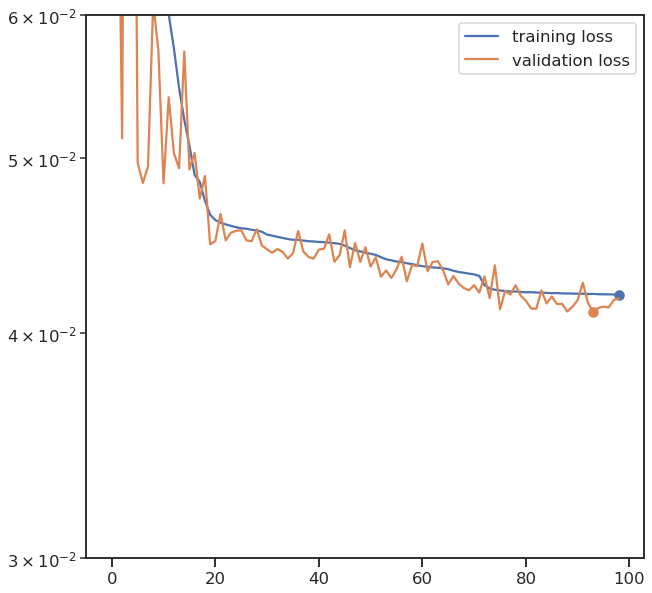

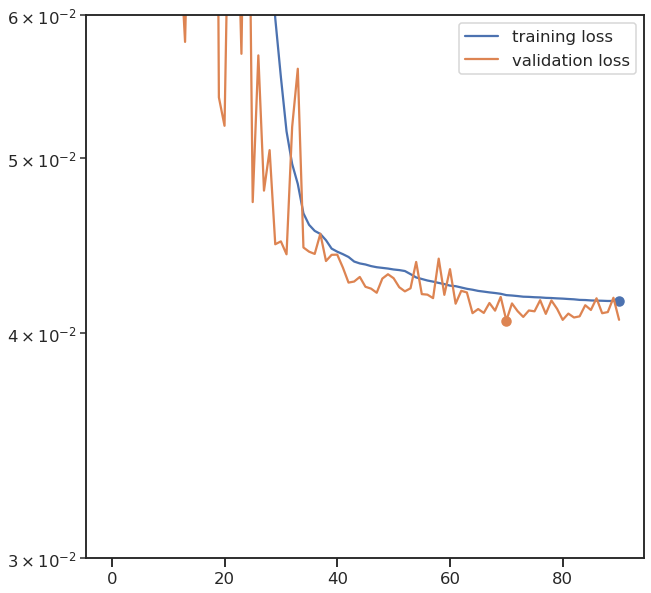

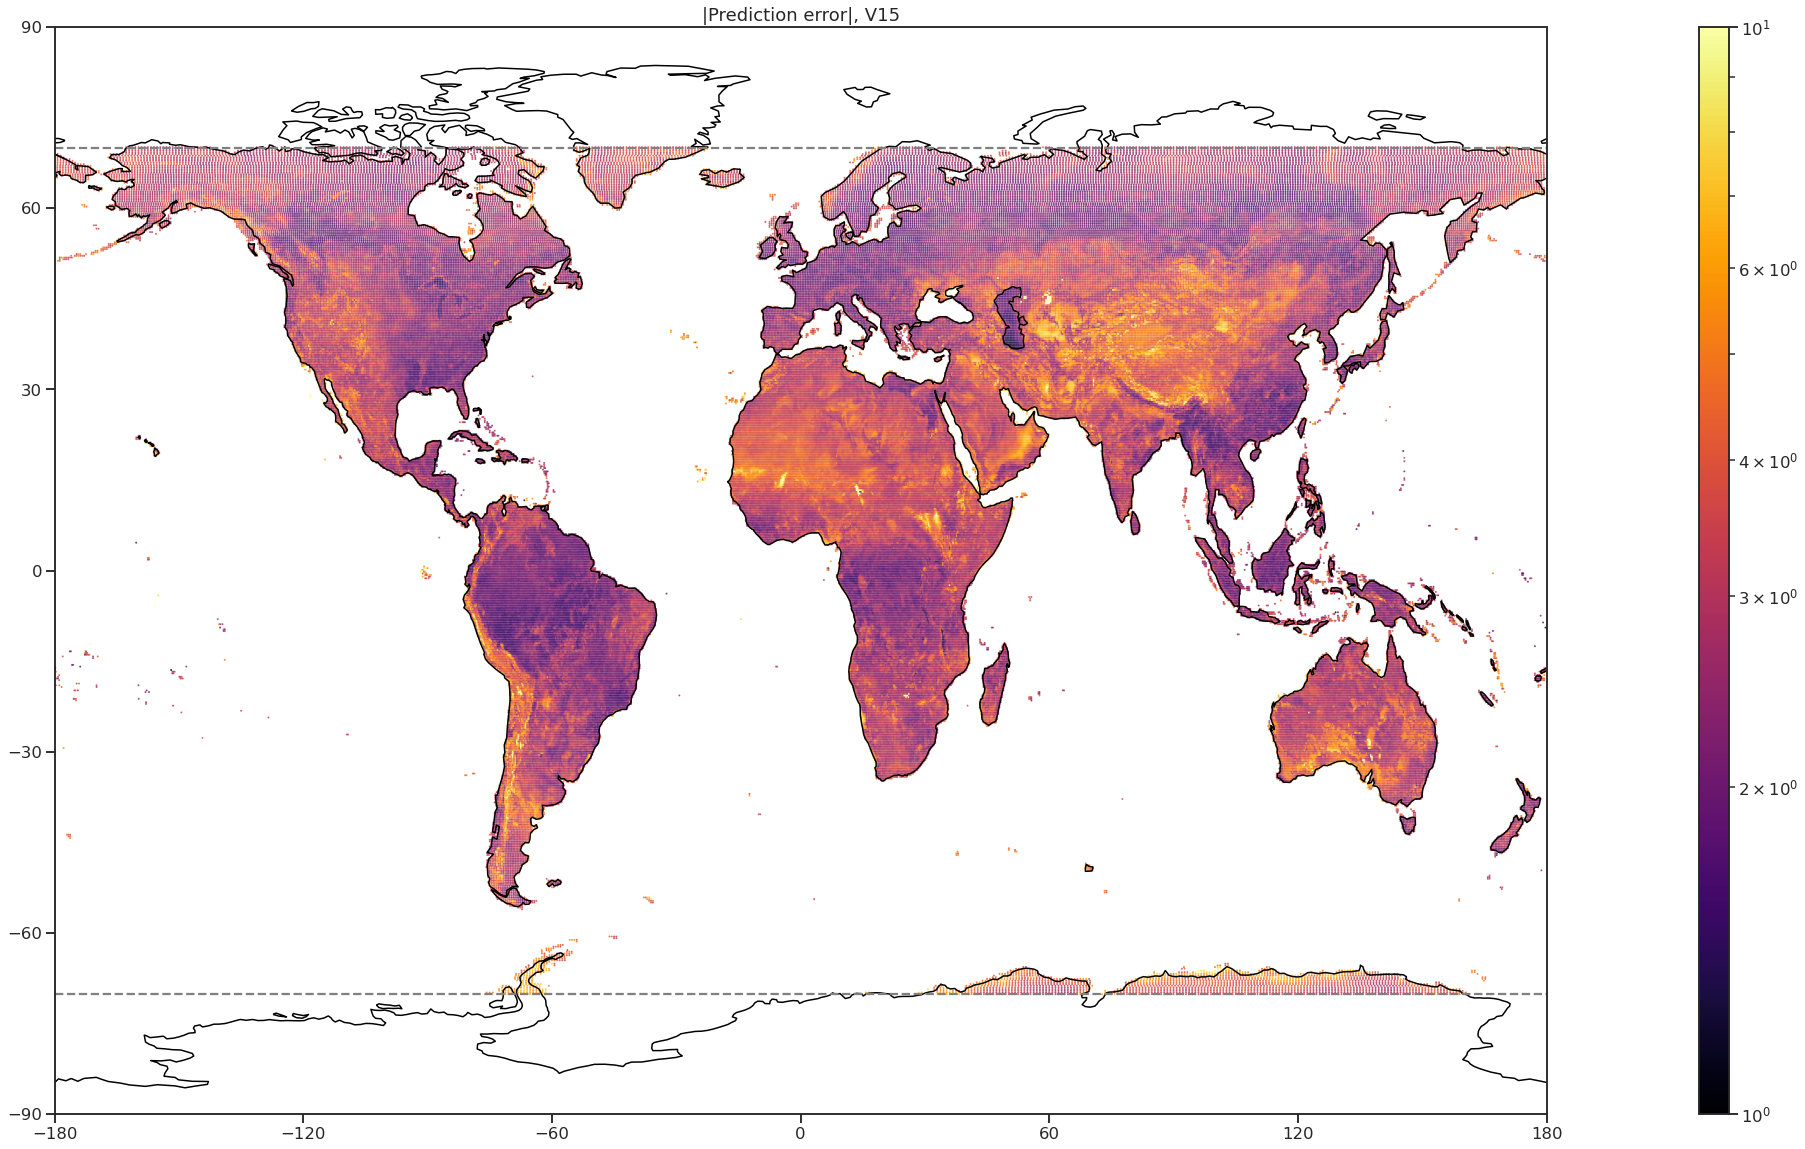

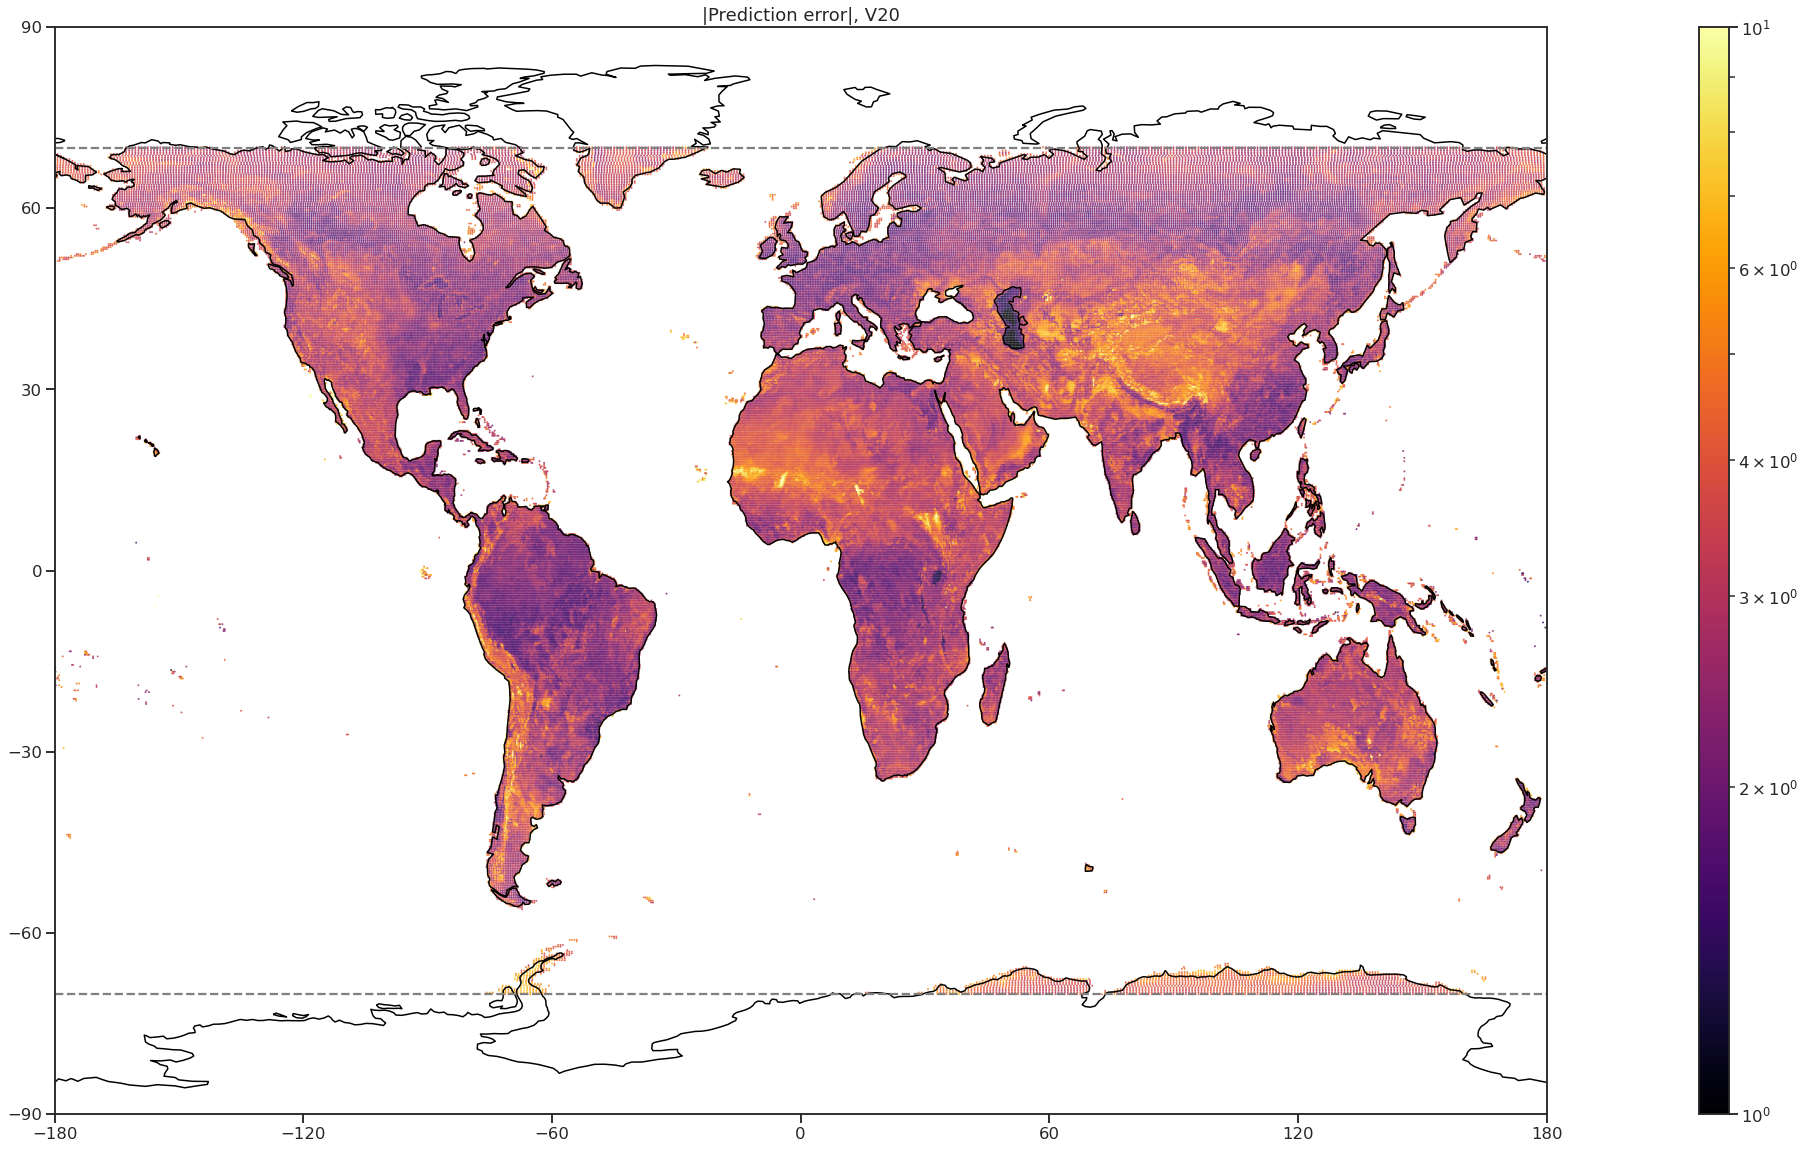

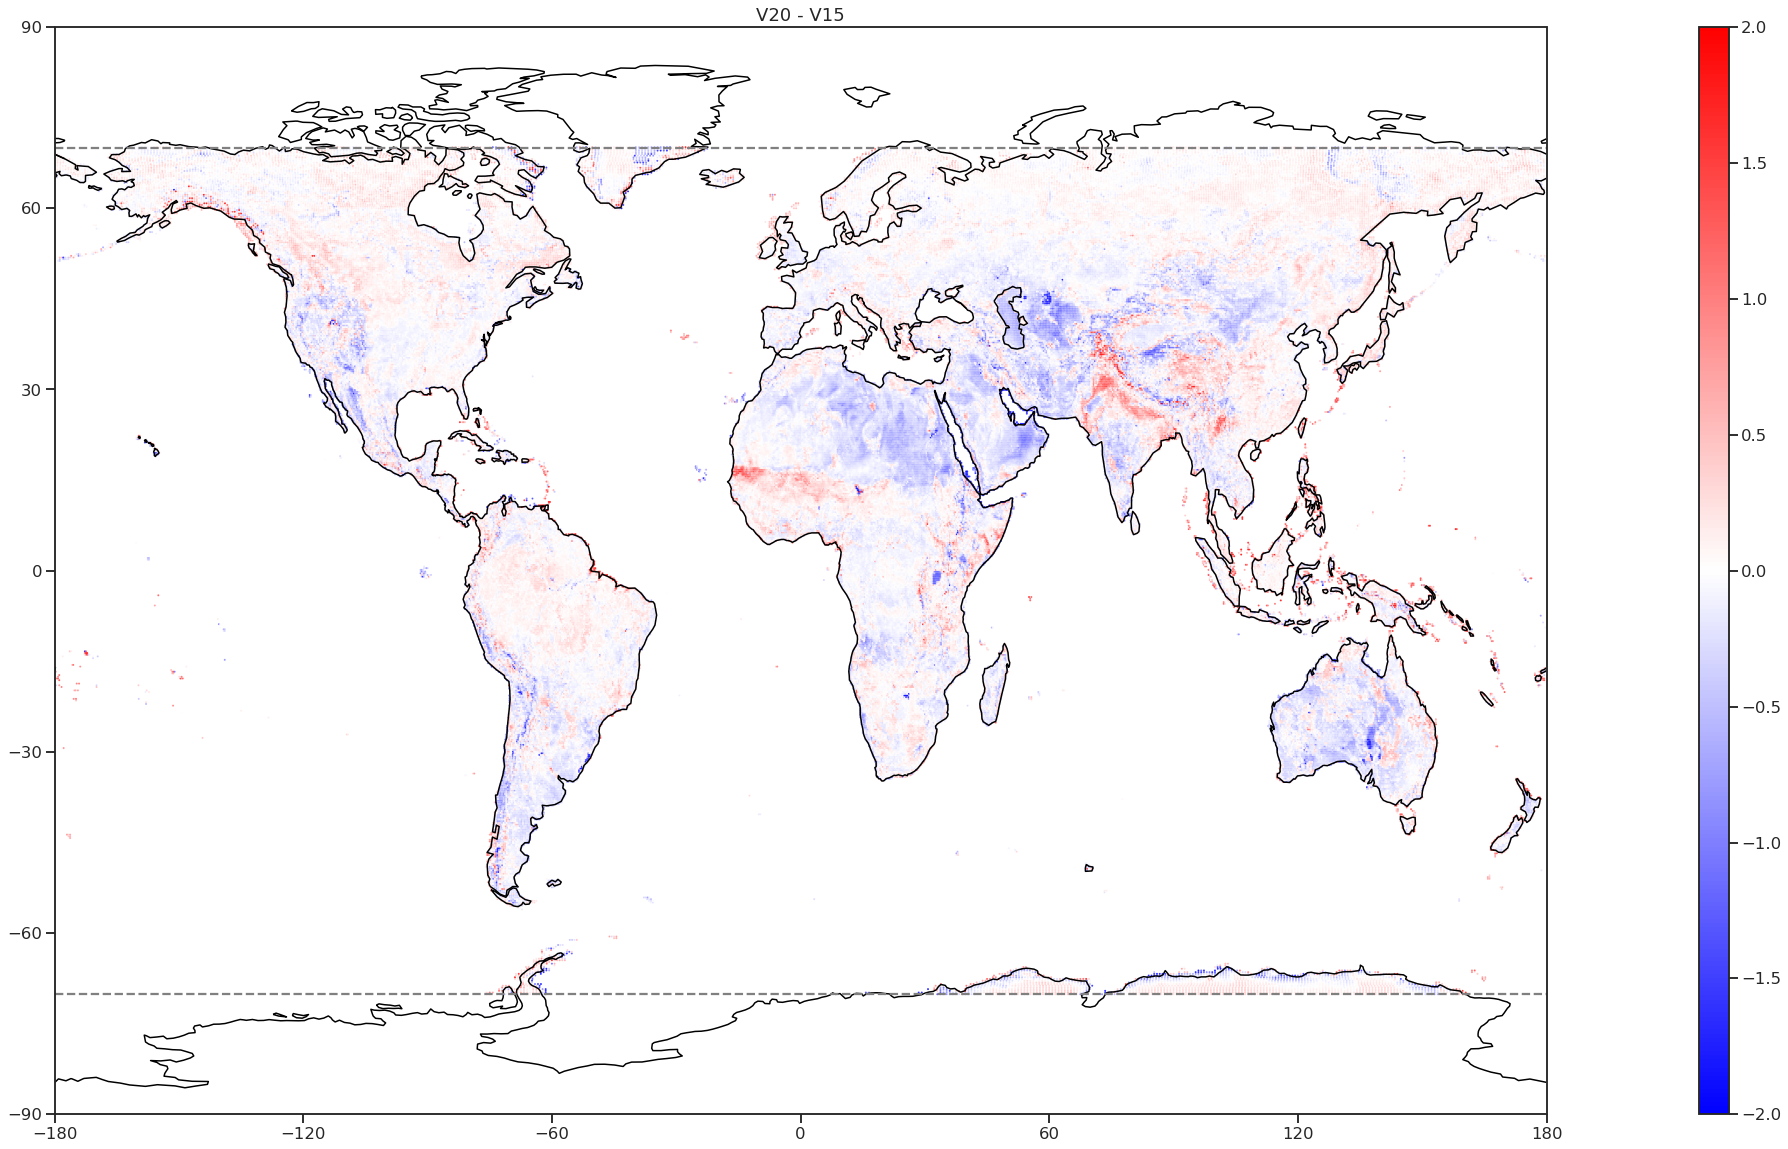

In [46]:

#Define the models to compare
models_root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/'
#modelV15 = models_root+'ML_5f6e838711334702b2fe6d9429c1a6ae/'#v15, batchsize 1024, LR 3e-4

modelV15 = models_root+'ML_963fe7a995c546b389402f21ef5eadd7/'#As above, with sea ice
modelV20 = models_root+'ML_1bac10ad60514426934b4709e78ddfb7/' #v20. batchsize 1024, LR 3e-4. 2 hidden layers


#modelV20 = models_root+'ML_792ce8ee7476412face8f0c36da82287/' #v20, batchsize 1024, LR 3e-4. OLD
# ML_d360eb7b7d0a4a45ad6eb421f1994552. v15, batchsize 10,000, LR 3e-4
#ML_6102888f3be74a08ba1324385b763f16 v20, batchsize 10,000, LR 3e-4

#Plotting parameters
cmap = plt.cm.inferno
logscale = True #None
vmin = 1
vmax = 10


#Process V15
V15 = load_predictions(modelV15) #Load data
V15_grouped = V15.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean() #averagee predictions over the year

#Process V20
V20 = load_predictions(modelV20)
V20_grouped = V20.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean()
    

#Plot training history, just for interest
plot_training_history(modelV15,logscale=True,jump_n_epochs=1,upper_limit = 6e-2,lower_limit=3e-2) 
plot_training_history(modelV20,logscale=True,jump_n_epochs=1,upper_limit = 6e-2,lower_limit=3e-2)
    
    
#Plot the map of the prediction error    
plot_map(V15_grouped,'absolute_model_error',vmin=vmin,vmax=vmax,cmap=cmap,logscale=logscale,title='|Prediction error|, V15',limits=None,markersize=1)
plot_map(V20_grouped,'absolute_model_error',vmin=vmin,vmax=vmax,cmap=cmap,logscale=logscale,title='|Prediction error|, V20',limits=None,markersize=1)

    
#Create a new df that will just hold the differences, and plot it    
data = {'latitude_ERA':   V20_grouped.latitude_ERA, 
        'longitude_ERA':  V20_grouped.longitude_ERA,
        'MODIS_LST':      V20_grouped.MODIS_LST,
        'V15_prediction': V15_grouped.predictions,
        'V20_prediction': V20_grouped.predictions,
        'V15_error':      V15_grouped.absolute_model_error,
        'V20_error':      V20_grouped.absolute_model_error,
        'delta':          V20_grouped.absolute_model_error - V15_grouped.absolute_model_error}
error_delta_field = pd.DataFrame(data)    
plot_map(error_delta_field,'delta',vmin=-2,vmax=+2,cmap=plt.cm.bwr,logscale=False,title='V20 - V15',limits=None,markersize=1)

---

# 2. Apply a mask


From this difference error map `V20-V15` it is hard to disentangle regions which have changed due to the improvement of the model, versus regions which have changed simply due to the inherent variability + stochasticity during training the model.

What we can do is **apply a mask to isolate just those regions where cl has been changed appreciably**. 



In [39]:
# First get the cl delta field. Go to `A1.V20_vs_V15.ipynb` to see this plotted
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'
version = ['v015', 'v020']
    
ds = [] #Array to hold results
for v in version:
    path = root+f'climate.{v}/climate.{v}/639l_2/clake'
    ds_i= xr.open_dataset(path,engine='cfgrib',backend_kwargs={'indexpath': ''},filter_by_keys={'shortName': 'cl'}) #only want cl 
    ds.append(ds_i)
        
#Take the difference, and make it a nice pandas df    
clake_delta_field = ds[1] - ds[0] #V20 - V15
clake_delta_field =  clake_delta_field.assign_coords({"longitude": (((clake_delta_field.longitude + 180) % 360) - 180)}) #long3 ---> long1
clake_delta_field = clake_delta_field.to_dataframe().reset_index()


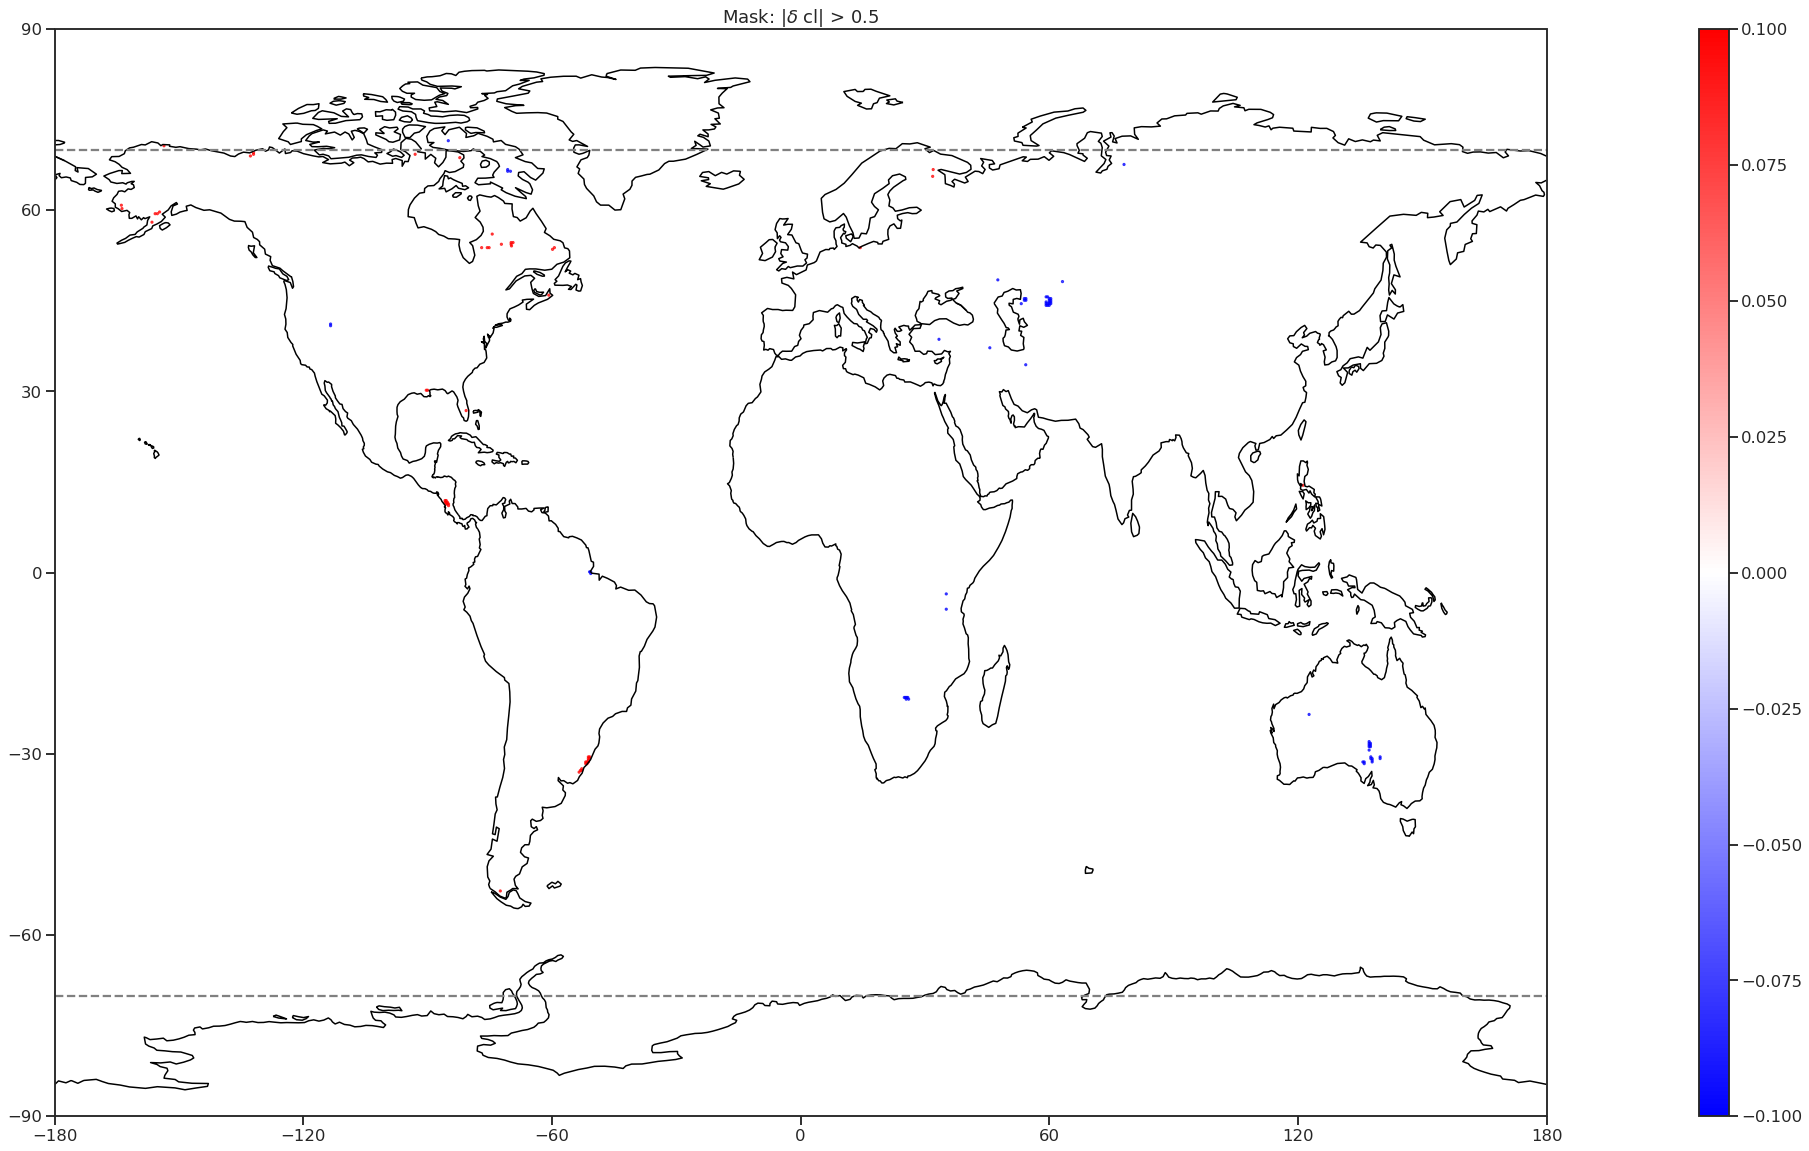

In [40]:
#Use cl delta field to create a mask 
p = 0.5 # cutoff paramter. Only get points with change in lake cover > p
mask = clake_delta_field.query(f'abs(cl) > {p}')

#Plot the mask
plot_map(mask,'cl',vmin=-0.1,vmax=0.1,cmap=plt.cm.bwr,logscale=False,title=f'Mask: |${{\delta}}$ cl| > {p}',limits=None,markersize=5) #What does this mask look like?

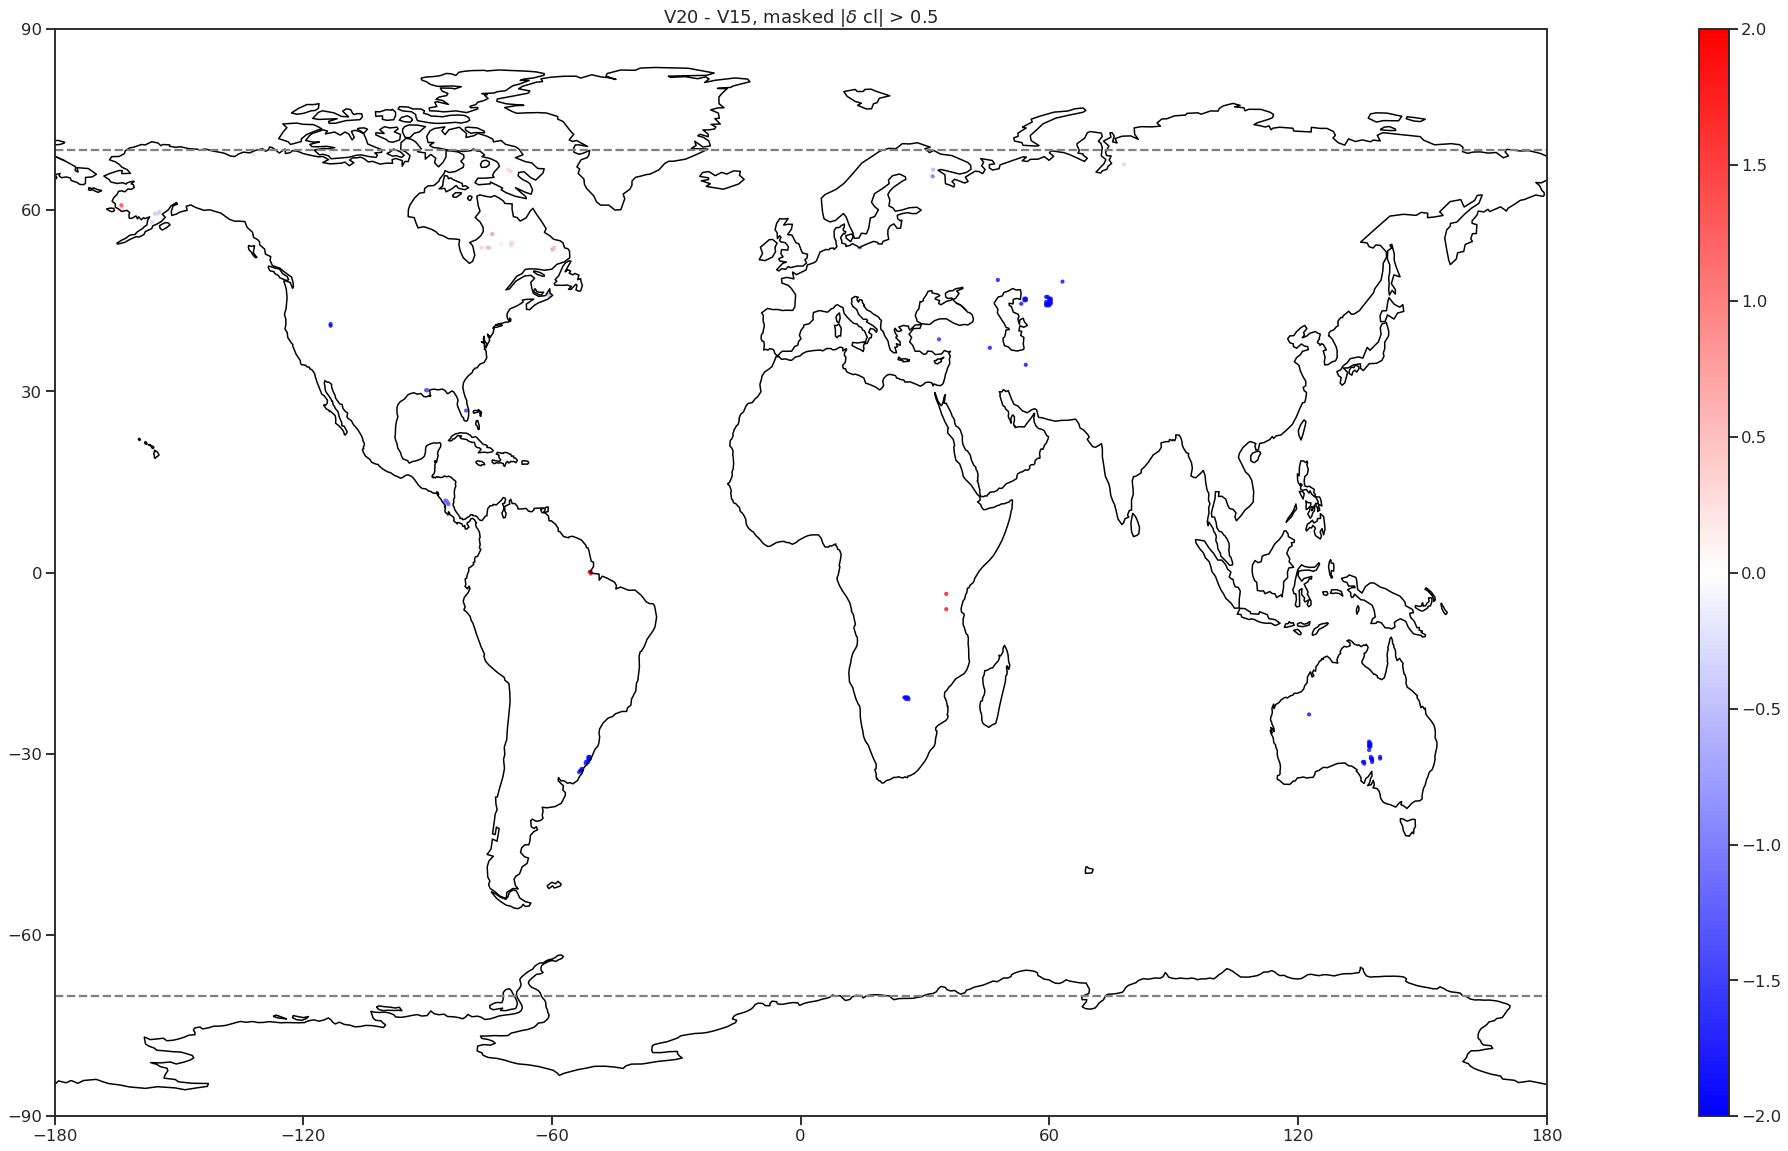

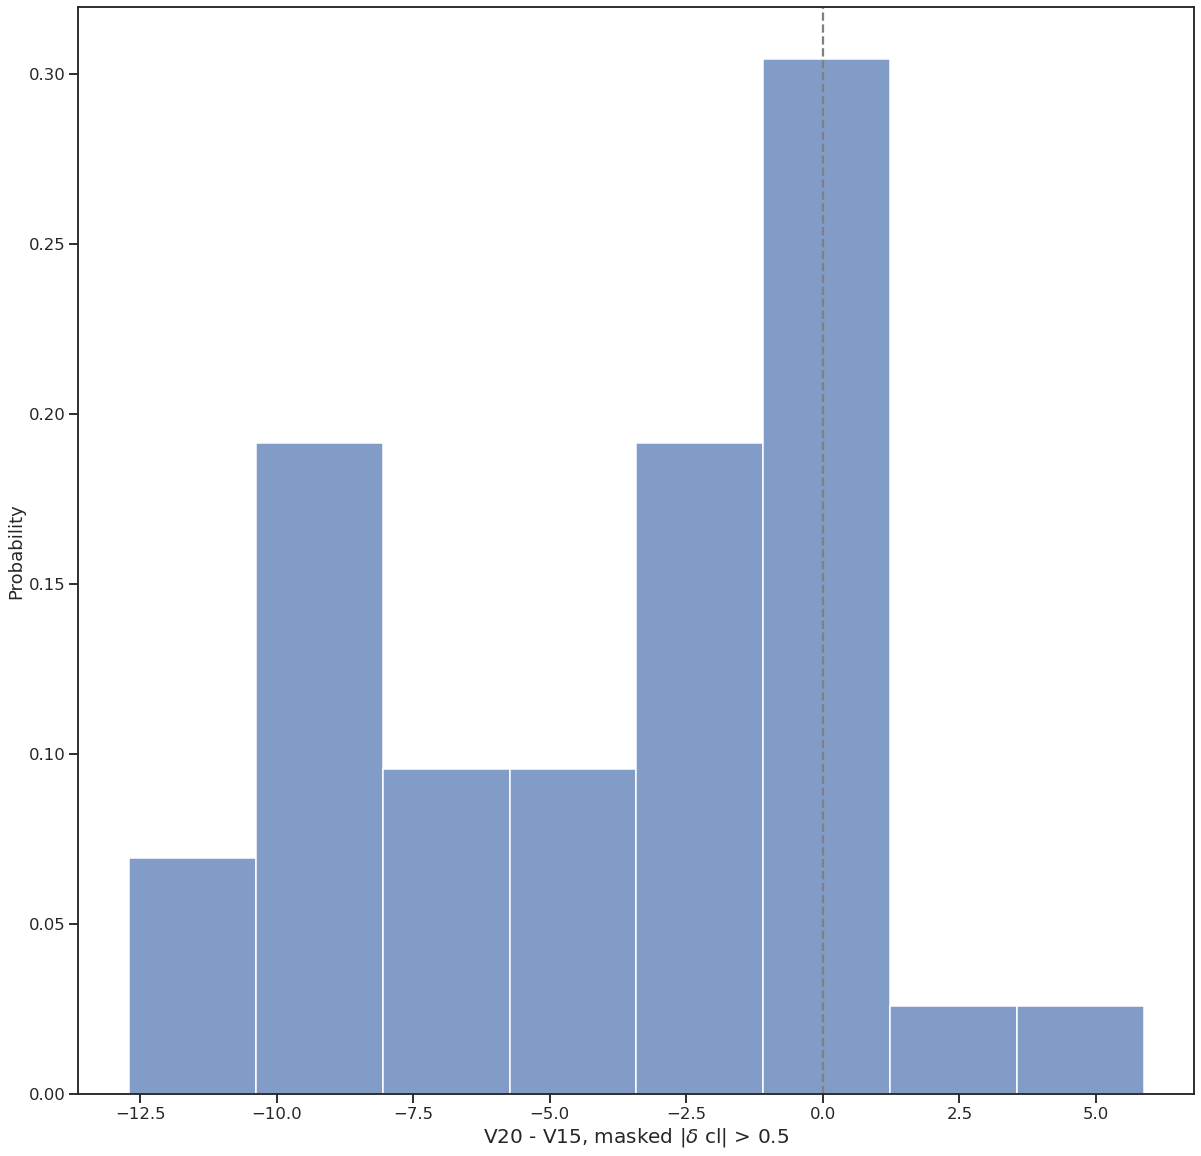

Mean change in model error = -3.8856688
Number of samples with |p| > 0.5 is: 115
Greatest improvement:


latitude_ERA  longitude_ERA  MODIS_LST  V15_prediction  V20_prediction  \
30     -28.24355       137.1875   315.2164      295.050568      307.929535   

    V15_error  V20_error      delta  values   step  surface  latitude  \
30  20.165833   7.466327 -12.699506  397456 0 days      0.0 -28.24355   

    longitude        cl  
30   137.1875 -0.998833

Worst improvement: 


latitude_ERA  longitude_ERA   MODIS_LST  V15_prediction  V20_prediction  \
40     -6.042153       35.15625  305.171234      301.793335      314.577148   

    V15_error  V20_error     delta  values   step  surface  latitude  \
40   3.531063   9.405912  5.874849  298045 0 days      0.0 -6.042153   

    longitude        cl  
40   35.15625 -0.727888

In [42]:
#Apply the mask to the global error_delta_field from section 1
masked_error_delta_field = pd.merge(error_delta_field,mask,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude', 'longitude']) #inner join.


# Plot it, along with a distribution of the errors
plot_map(masked_error_delta_field,
         'delta',
         vmin=-2,vmax=+2,
         cmap=plt.cm.bwr,
         logscale=False,
         title=f'V20 - V15, masked |${{\delta}}$ cl| > {p}',
         limits=None,
         markersize=10)
    
plot_distribution(masked_error_delta_field,
                  'delta',
                  bins='auto',
                  xlabel = f'V20 - V15, masked |${{\delta}}$ cl| > {p}')





#Surface some numbers
print('Mean change in model error =', masked_error_delta_field.delta.mean())
print (f'Number of samples with |p| > {p} is:',  len(masked_error_delta_field))
print ('Greatest improvement:')
display(masked_error_delta_field[masked_error_delta_field.delta == masked_error_delta_field.delta.min()])  #small numbers show V20 > V15
print ('Worst improvement: ') 
display(masked_error_delta_field[masked_error_delta_field.delta == masked_error_delta_field.delta.max()])  #Large numbers show V20 < V15

---

# 3. Analysis

In [43]:
display(masked_error_delta_field.sort_values(by=['delta'],ascending=False).head(20))

latitude_ERA  longitude_ERA   MODIS_LST  V15_prediction  V20_prediction  \
40      -6.042153      35.156250  305.171234      301.793335      314.577148   
41      -3.512879      35.156250  301.797272      299.813934      309.993744   
42      -0.140515     -50.625000  300.542664      302.529663      306.432251   
44       0.140515     -50.625000  299.526062      302.133148      305.706757   
43       0.140515     -50.906250  301.339539      302.253937      306.484497   
104     60.843060    -163.888889  272.198792      270.605469      268.748199   
98      56.065548     -74.400000  269.618347      269.067535      267.094360   
87      53.536276     -59.850000  275.515503      275.415009      272.465942   
91      53.817306     -59.400000  273.679596      274.199860      271.126648   
90      53.817306     -75.150000  272.388916      273.000977      269.943115   
103     60.281000    -163.733333  272.348053      272.776703      270.729431   
109     67.587780      78.046875  267.885986      268.971008      271.251160   
106     66.463660     -70.000000  261.994904      262.191040      264.909668   
88      53.817306     -76.950000  273.364410      273.179382      270.916077   
107     66.744690     -70.666667  261.724915      262.192566      264.487518   
96      54.660397     -69.843750  270.000671      270.113800      267.894958   
97      54.660397     -69.375000  269.595520      270.094421      267.755310   
94      54.379367     -72.187500  270.896057      271.492798      269.719849   
93      54.098337     -69.750000  269.211700      270.052856      268.182159   
110     68.711899     -82.222222  258.769928      259.938873      257.836304   

     V15_error  V20_error     delta  values   step  surface   latitude  \
40    3.531063   9.405912  5.874849  298045 0 days      0.0  -6.042153   
41    2.596229   8.248317  5.652088  286525 0 days      0.0  -3.512879   
42    2.272953   5.889603  3.616650  272140 0 days      0.0  -0.140515   
44    2.792777   6.180697  3.387920  270860 0 days      0.0   0.140515   
43    2.276047   5.147219  2.871172  270859 0 days      0.0   0.140515   
104   4.102893   5.618123  1.515230   35401 0 days      0.0  60.843060   
98    3.401017   4.282820  0.881803   47598 0 days      0.0  56.065548   
87    3.349356   4.213339  0.863983   54592 0 days      0.0  53.536276   
91    3.206817   3.813409  0.606592   53793 0 days      0.0  53.817306   
90    3.393849   3.980205  0.586356   53758 0 days      0.0  53.817306   
103   2.848903   3.313258  0.464355   36712 0 days      0.0  60.281000   
109   4.134634   4.594995  0.460361   21099 0 days      0.0  67.587780   
106   4.951047   5.408272  0.457225   23527 0 days      0.0  66.463660   
88    3.137098   3.553564  0.416466   53754 0 days      0.0  53.817306   
107   4.925682   5.295480  0.369799   22986 0 days      0.0  66.744690   
96    3.481910   3.816056  0.334146   51408 0 days      0.0  54.660397   
97    3.425376   3.719619  0.294242   51409 0 days      0.0  54.660397   
94    3.035407   3.232067  0.196660   52171 0 days      0.0  54.379367   
93    3.845930   4.034193  0.188263   52970 0 days      0.0  54.098337   
110   3.005332   3.151577  0.146245   19377 0 days      0.0  68.711899   

      longitude        cl  
40    35.156250 -0.727888  
41    35.156250 -0.638541  
42   -50.625000 -0.588097  
44   -50.625000 -0.603153  
43   -50.906250 -0.604843  
104 -163.888889  0.707572  
98   -74.400000  0.509592  
87   -59.850000  0.685262  
91   -59.400000  0.705363  
90   -75.150000  0.700038  
103 -163.733333  0.648723  
109   78.046875 -0.548265  
106  -70.000000 -0.725923  
88   -76.950000  0.525927  
107  -70.666667 -0.649780  
96   -69.843750  0.616873  
97   -69.375000  0.603343  
94   -72.187500  0.731721  
93   -69.750000  0.637807  
110  -82.222222  0.549671

# Appendix

Old material

In [ ]:






#Get a map of the original V15 lsm. This will only be used to get rid of oceans
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'
lsm_path = root+f'climate.v015/climate.v015/639l_2/lsmoro'
ds_lsm= xr.open_dataset(lsm_path,engine='cfgrib',backend_kwargs={'indexpath': ''},filter_by_keys={'shortName': 'lsm'}) 
ds_lsm = correct_longitude(ds_lsm)
lsm_df = ds_lsm.to_dataframe().reset_index() #Make it a df
all_fields = lsm_df.copy()



#Now look at all the features which are changing
changing_features = ['cl','lsm','dl','cvl','cvh','anor','isor','slor','sr','lsrh']
changing_files =    ['clake','lsmoro','lakedl','sfc','sfc','sfc','sfc','sfc','sfc','sfc']


for i in range(len(changing_features)): 
    file = changing_files[i]
    feature=changing_features[i]
    delta = difference_in_surface_fields(file,feature)
    
    all_fields[f'delta_{feature}'] = delta[feature].values
    
    
    
    
print ('Plotting map of changing features')
for f in changing_features: 
    plot_map(all_fields,f'delta_{feature}',vmin=1e-2,vmax=10,cmap=plt.cm.bwr,logscale=True,title=f'Change in {feature}',limits=limits,markersize=1)
    
    
# #We can define some masks based on how we want to filter the data
# strong_mask = all_fields.query('abs(delta_cl) > 0.1 & abs(delta_lsm) > 0.0 & abs(delta_dl)>0.0 & abs(delta_cvl) > 0.0 & abs(delta_cvh) > 0.0')
# weak_mask = all_fields.query('abs(delta_cl) > 0.1')

# plot_map(all_fields,'delta_cl',vmin=-0.05,vmax=+0.01,cmap=plt.cm.bwr,logscale=False,title='Change in lake cover',limits=limits,markersize=1)
# plot_map(strong_mask,'delta_cl',vmin=1e-1,vmax=+1,cmap=plt.cm.bwr,logscale=True,title=f'Strong Mask: Change in Lake cover cl',limits=None,markersize=10) #What does this mask look like?
# plot_map(weak_mask,'delta_cl',vmin=1e-1,vmax=+1,cmap=plt.cm.bwr,logscale=True,title=f'Weak Mask, Change in Lake cover cl',limits=None,markersize=10) #What does this mask look like?





# #Now look at all the features which are changing
# changing_features = ['cl','lsm','dl','cvl','cvh','anor','isor','slor','sr','lsrh']
# changing_files =    ['clake','lsmoro','lakedl','sfc','sfc','sfc','sfc','sfc','sfc','sfc']


# for i in range(len(changing_features)): 
#     file = changing_files[i]
#     feature=changing_features[i]
#     delta = difference_in_surface_fields(file,feature)
    
#     all_fields[f'delta_{feature}'] = delta[feature].values
    
    
    
    
# print ('Plotting map of changing features')
# for f in changing_features: 
#     plot_map(all_fields,f'delta_{feature}',vmin=1e-2,vmax=10,cmap=plt.cm.bwr,logscale=True,title=f'Change in {feature}',limits=limits,markersize=1)

    

In [ ]:
# from matplotlib.gridspec import GridSpec
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import xarray as xr
# import matplotlib.colors as mc
# import matplotlib.colorbar as cb 




# def correct_longitude(ds):    
#     return ds.assign_coords({"longitude": (((ds.longitude + 180) % 360) - 180)})


# def plot_map(ds,z,vmin,vmax,cmap,logscale,title,limits,markersize):
    
#     """Scatter plot. Bit hacky. """

#     try:
#         x = ds.longitude
#         y = ds.latitude
#     except: #different sources call lat/lon different things
#         x = ds.longitude_ERA
#         y = ds.latitude_ERA
    
#     z1 = ds[z]
    

    
#     #Setup figure and axes
#     fig = plt.figure(figsize=[30,20])
#     gs = GridSpec(1, 2, figure=fig, width_ratios=[50,1])
#     ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=0))
#     cax = fig.add_subplot(gs[1])
    
#     #Cmaps, normalisations
#     if logscale:
#         norm = mc.LogNorm(vmin=vmin, vmax=vmax)
#         z1 = abs(z1)
#     else:
#         norm = mc.Normalize(vmin=vmin, vmax=vmax)

    
#     cb1 = cb.ColorbarBase(cax, cmap=cmap,
#                                 norm=norm,
#                                 orientation='vertical')
    
    
    
#     #Plot it
#     sc=ax.scatter(x,y,s=markersize,c=cmap(norm(z1)),
#                 linewidths=1, alpha=.7)

    
#     #Tidy up
#     ax.axhline(70, c='0.5', linestyle='--')
#     ax.axhline(-70, c='0.5', linestyle='--') #latitude cutoffs

#     ax.set_title(title)    
#     ax.coastlines()

    
#     ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
#     ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
#     ax.set_aspect('auto') #Force projection aspect ratio
    
#     if limits is not None:
#         ax.set_xlim(limits['xlow'],limits['xhigh'])
#         ax.set_ylim(limits['ylow'],limits['yhigh'])
#         ax.set_xticks([])
#         ax.set_yticks([])

#     plt.show()
    
    
    
    
# def difference_in_surface_fields(file,feature):
    
    
#     version = ['v015', 'v020']
    
#     ds = [] #Array to hold results
#     for v in version:
#         path = root+f'climate.{v}/climate.{v}/639l_2/{file}'
#         ds_i= xr.open_dataset(path,engine='cfgrib',backend_kwargs={'indexpath': ''},filter_by_keys={'shortName': feature}) 
#         ds.append(ds_i)
        
        
    
#     #Take the difference    
#     delta = ds[1] - ds[0] #V20 - V15
#     delta = correct_longitude(delta) #long3 ---> long1
    
#     return delta
    